<a href="https://colab.research.google.com/github/on-kulyashov/Code-for-NMR-course/blob/main/HW_9_Kulyashov.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

sigma = 0.7532180959058272


ValueError: ignored

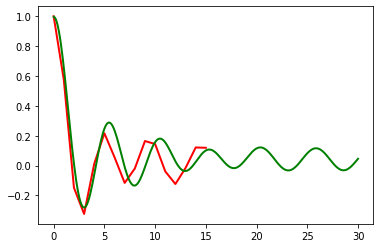

In [ ]:
import numpy as np
from scipy.linalg import *
import matplotlib.pyplot as plt
from collections import Counter



# -- start of old home work --
# initial spin generation
def init_spins(num=1):
    s_0 = np.sqrt(3)/2
    spins = []
    def one_spin():
        phi_0 = np.random.uniform(0, 2*np.pi)
        s_z = np.random.uniform(-1, 1)
        return [np.sqrt(1 - s_z**2)*np.cos(phi_0), np.sqrt(1 - s_z**2)*np.sin(phi_0), s_z]
    for i in range(num):
        spins.extend(one_spin())
    return s_0 * np.array(spins)


def init_spins_polarized(num=1):
    s_0 = np.sqrt(3)/2
    spins = []
    def one_spin():
        phi_0 = np.random.uniform(0, 2*np.pi)
        p = np.random.uniform()
        s_x = (np.sqrt(40*p + 81) - 10)
        return [s_x, np.sqrt(1 - s_x**2)*np.cos(phi_0), np.sqrt(1 - s_x**2)*np.sin(phi_0)]
    for i in range(num):
        spins.extend(one_spin())
    return s_0 * np.array(spins)    


# RK4 method    
def yn1(f, yn, xn, h):
    k1 = f(xn, yn)
    k2 = f(xn + h/2, yn + h*k1/2)
    k3 = f(xn + h/2, yn + h*k2/2)
    k4 = f(xn + h, yn + h*k3)
    return yn + h/6 * (k1 + 2*k2 + 2*k3 + k4)


def integrate(f, a, b, y_a, h):
    sol = [y_a]
    for i in range(int((b-a)//h) + 1):
        sol.append(yn1(f, sol[-1], a + i*h, h))
    return sol

# evolution parameters
J_perp = -0.41
J_z = 0.82
N = 11
ensemble = 2
ensemble_direct = 2
t_1, t_2 = 0, 150
t_1_direct, t_2_direct = 0, 15
h = 0.01
t_delay_max = 15
t_decay = np.linspace(0, t_delay_max, num=t_delay_max+1)


def classical(t, s):
    s_individual = [s[i:i + 3] for i in range(0, len(s), 3)]
    evolve = []
    for i in range(N):
        pre = (i - 1 + N) % N
        aft = (i + 1 + N) % N
        h = -np.array([J_perp*(s_individual[pre][0] + s_individual[aft][0]), J_perp*(s_individual[pre][1] + s_individual[aft][1]), J_z*(s_individual[pre][2] + s_individual[aft][2])])
        evolve.extend(np.cross(s_individual[i], h))
    return np.array(evolve)


def convolution(f1, f2, t_delay):
    sum = 0
    t_delay = int(len(f2)*t_delay/(t_2 - t_1))
    integration_interval = int(len(f2)*(t_2 - t_1 - t_delay_max)/(t_2-t_1)) - 1
    for i in range(integration_interval):
        sum += f1[i]*f2[i + t_delay]
    return sum

s_evol_length = []
def free_decay(evol_operator, t_decay):
    free_ind_decay = []
    s_evol = integrate(evol_operator, t_1, t_2, init_spins(num=N), h)
    s_evol_length.append([np.sqrt(sum([s[i]**2 for i in range(3)])) for s in s_evol])
    s_evol_x_sum = [sum([s[i] for i in range(0, len(s), 3)]) for s in s_evol]
    for delay in t_decay:
        free_ind_decay.append(convolution(s_evol_x_sum, s_evol_x_sum, delay))
    return np.array(free_ind_decay)

s_evol_length_direct = []
def free_decay_direct(evol_operator, t_decay):
    free_ind_decay = []
    s_evol = integrate(evol_operator, t_1_direct, t_2_direct, init_spins_polarized(num=N), h)
    s_evol_x_sum = np.array([sum([s[i] for i in range(0, len(s), 3)]) for s in s_evol])
    s_evol_length_direct.append([np.sqrt(sum([s[i]**2 for i in range(3)])) for s in s_evol])
    free_ind_decay = s_evol_x_sum / s_evol_x_sum[0]
    return np.array(free_ind_decay)      

fid = [np.array(free_decay(classical, t_decay))]
for i in range(ensemble-1):
    fid.append(free_decay(classical, t_decay))
fid = np.array(fid)
f_sum = fid.sum(axis=0)/(fid.sum(axis=0)[0])
fid_half = fid[:(len(fid)//2)]
f_sum_half = fid_half.sum(axis=0)/(fid_half.sum(axis=0)[0])

fid_direct = [np.array(free_decay_direct(classical, t_decay))]
for i in range(ensemble_direct-1):
    fid_direct.append(free_decay_direct(classical, t_decay))
f_sum_direct = np.sum(np.array(fid_direct), axis=0)/(len(fid_direct))
fid_direct_half = fid_direct[:(len(fid_direct)//2)]
f_sum_direct_half = np.sum(np.array(fid_direct_half), axis=0)/len(fid_direct_half)

# -- end of old home work --



pauli = np.array([ [[0,1],[1,0]], [[0,-1j],[1j,0]], [[1,0],[0,-1]] ]) / 2
dbl_pauli = np.array([np.kron(a,a) for a in pauli])

N = 9
Jz = 0.82
Jp = -0.41
hx = np.zeros(N)
hx2 = 0
hz = np.zeros(N)
hz2 = 0
t_1 = 0
t_2 = 30

# hamiltonian construction
def Hamiltonian(Jz, Jp, hx, hz):
    H = np.zeros(2**N)
    H = H + Jz*np.kron(np.kron(pauli[2], np.eye(2**(N-2))), pauli[2])
    H = H + Jp*np.kron(np.kron(pauli[1], np.eye(2**(N-2))), pauli[1])
    H = H + Jp*np.kron(np.kron(pauli[0], np.eye(2**(N-2))), pauli[0])
    for i in range(N-1):
        H = H + Jz*np.kron(np.kron(np.eye(2**i), dbl_pauli[2]), np.eye(2**(N-2-i)))
        H = H + Jp*np.kron(np.kron(np.eye(2**i), dbl_pauli[1]), np.eye(2**(N-2-i)))
        H = H + Jp*np.kron(np.kron(np.eye(2**i), dbl_pauli[0]), np.eye(2**(N-2-i)))
    for i in range(N):
        H = H + hx[i]*np.kron(np.kron(np.eye(2**i), pauli[0]), np.eye(2**(N-1-i)))
        H = H + hz[i]*np.kron(np.kron(np.eye(2**i), pauli[2]), np.eye(2**(N-1-i)))
    return np.real_if_close(H)
H = Hamiltonian(Jz, Jp, hx, hz)
H, V = np.linalg.eig(H)
E = np.real_if_close(np.sort(H))

def distrib(E, bins=20):
    distribution = np.zeros(bins)
    dE = (E[-1] - E[0]) / bins
    energy_levels = np.arange(1, bins+1) * dE + E[0]
    i = 0
    for e in E:
        if e <= energy_levels[i]:
            distribution[i] += 1
        else:
            i += 1
    return energy_levels, distribution

# sum of polarizations in new basis
S = np.zeros(2**N)
for i in range(N):
    S = S + np.kron(np.kron(np.eye(2**i), pauli[0]), np.eye(2**(N-1-i)))
S_total_polar = S
S = np.matmul(np.matmul(np.transpose(V), S), V)

# evolution operator
def u(t):
    return np.diag(np.exp(1j*t*H))

# fid 
def f(t):
    return np.trace(np.matmul(np.matmul(np.matmul(u(t),S),u(-t)),S))/(N*(2**(N-2)))

# spectrum distribution
energy_levels, distribution = distrib(E)
sigma = np.sqrt(N*((Jz**2 + 2*Jp**2)/16 + (hx2**3 + hz2**3)/6))
print("sigma = {}".format(sigma))
gauss = (2**N / sigma / np.sqrt(2*np.pi)) * np.array([np.exp(-(e**2) / (2 * sigma**2)) for e in energy_levels])

# energy spacing distributions
central_E = np.array([e for e in E if (e >= -sigma / 3 and e <= sigma / 3)])
spacings_E = np.array([central_E[i + 1] - central_E[i] for i in range(len(central_E)-1)]) / (2*sigma / 3)
e_0 = 0
nu_0 = (2**N / sigma / np.sqrt(2*np.pi)) * np.exp(-(e_0**2) / (2 * sigma**2))

def WD_dist(dE):
    return (np.pi/2)*(dE * (nu_0**2))* np.exp(-(np.pi/4)*((dE**2) * (nu_0**2)))

def poiss_dist(dE):
    return nu_0 * np.exp(-dE * nu_0)

# inf. temperature wave function
phi = np.random.uniform(0, 2*np.pi, size=(2**N))
c = np.sqrt(np.random.exponential(scale=(1/(2**N)), size=(2**N)))
psi_infty = c*np.exp(1j*phi)

# zero time wave function
T = 10
h = 0.01

def im_time_evol(t, psi):
    H = S_total_polar
    return np.matmul(-H, psi)

psi_zero = integrate(im_time_evol, 0, 1/(2*T), psi_infty, h)[-1]

# re. time evolution
def re_time_evol(t, psi):
    H = Hamiltonian(Jz, Jp, hx, hz)
    return np.matmul(-1j*H, psi)

fid_time_integr = [np.matmul(psi, np.matmul(S_total_polar, psi)) for psi in integrate(re_time_evol, t_1, t_2, psi_zero, h)]
fid_time_integr = np.real_if_close(fid_time_integr / fid_time_integr[0])

# plotting
time = np.linspace(t_1, t_2, num=300)
fid = np.real_if_close(np.array([f(t) for t in time]))
plt.plot(t_decay, f_sum, 'r-', linewidth=2.0)
plt.plot(time, fid, 'g-', linewidth=2.0)
plt.plot(time, fid_time_integr, 'b-', linewidth=2.0)
plt.xlabel("t")
plt.ylabel("F(t)")
plt.legend(["Fid"])
plt.grid()
plt.show()

# plt.plot(energy_levels, distribution, 'g-', linewidth=2.0)
plt.hist(E, 4)
plt.plot(energy_levels, gauss, 'r-', linewidth=2.0)
plt.xlabel("E")
plt.ylabel("n(e)")
plt.legend(["Energy distribution 2"])
plt.grid()
plt.show()

min_dE = np.amin(spacings_E)
max_dE = np.amax(spacings_E)
print("Bins = {}".format(int((10 * (max_dE - min_dE) * nu_0) / 3)))
spacings_E_coverage = np.linspace(min_dE, max_dE)
plt.hist(spacings_E, 15)
plt.plot(spacings_E_coverage, WD_dist(spacings_E_coverage), 'r-', linewidth=2.0)
plt.plot(spacings_E_coverage, poiss_dist(spacings_E_coverage), 'g-', linewidth=2.0)
plt.xlabel("dE")
plt.ylabel("n(e)")
plt.legend(["Energy spacings distribution 2", "Wigner-Dyson", "Poisson"])
plt.grid()
plt.show()

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


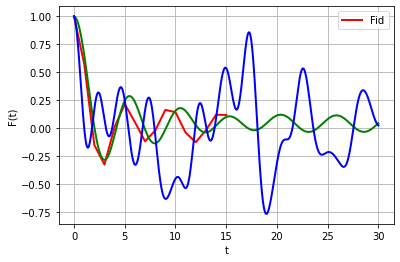

In [ ]:
# plotting
time = np.linspace(t_1, t_2, num=300)
time_integr = np.linspace(t_1, t_2, num=300)
fid = np.real_if_close(np.array([f(t) for t in time]))
plt.plot(t_decay, f_sum, 'r-', linewidth=2.0)
plt.plot(time, fid, 'g-', linewidth=2.0)
plt.plot(np.linspace(t_1, t_2, num=len(fid_time_integr)), fid_time_integr, 'b-', linewidth=2.0)
plt.xlabel("t")
plt.ylabel("F(t)")
plt.legend(["Fid"])
plt.grid()
plt.show()

Energy =  -1.75  :: Multiplicity =  18
Energy =  -0.75  :: Multiplicity =  168
Energy =  0.25  :: Multiplicity =  252
Energy =  1.25  :: Multiplicity =  72
Energy =  2.25  :: Multiplicity =  2
sigma = 0.75


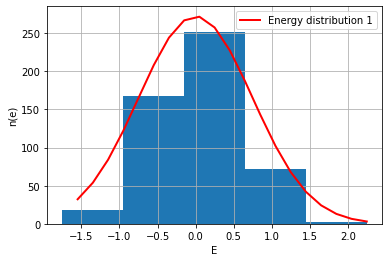

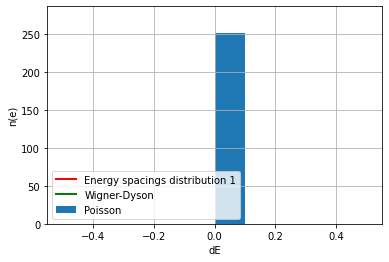

In [ ]:
Jz = 1
Jp = 0
hx2 = 0
hx = np.zeros(N)
hz2 = 0
hz = np.zeros(N)
H = Hamiltonian(Jz, Jp, hx, hz)
H, _ = np.linalg.eig(H)
E = np.real_if_close(np.sort(H))

dictOfElems = dict(Counter(list(E)))
for key, value in dictOfElems.items():
        print('Energy = ' , key , ' :: Multiplicity = ', value)  

energy_levels, distribution = distrib(E)
sigma = np.sqrt(N*((Jz**2 + 2*Jp**2)/16 + (hx2**3 + hz2**3)/6))
print("sigma = {}".format(sigma))
gauss = (2**N / sigma / np.sqrt(2*np.pi)) * np.array([np.exp(-(e**2) / (2 * sigma**2)) for e in energy_levels])

central_E = np.array([e for e in E if (e >= -sigma / 3 and e <= sigma / 3)])
spacings_E = np.array([central_E[i + 1] - central_E[i] for i in range(len(central_E)-1)]) / (2*sigma / 3)
e_0 = 0
nu_0 = (2**N / sigma / np.sqrt(2*np.pi)) * np.exp(-(e_0**2) / (2 * sigma**2))

# plt.plot(energy_levels, distribution, 'g-', linewidth=2.0)
plt.hist(E, 5)
plt.plot(energy_levels, gauss, 'r-', linewidth=2.0)
plt.xlabel("E")
plt.ylabel("n(e)")
plt.legend(["Energy distribution 1"])
plt.grid()
plt.show()

min_dE = np.amin(spacings_E)
max_dE = np.amax(spacings_E)
# print("Bins = {}".format(int((10 * (max_dE - min_dE) * nu_0) / 3)))
spacings_E_coverage = np.linspace(min_dE, max_dE)
plt.hist(spacings_E)
plt.plot(spacings_E_coverage, WD_dist(spacings_E_coverage), 'r-', linewidth=2.0)
plt.plot(spacings_E_coverage, poiss_dist(spacings_E_coverage), 'g-', linewidth=2.0)
plt.xlabel("dE")
plt.ylabel("n(e)")
plt.legend(["Energy spacings distribution 1", "Wigner-Dyson", "Poisson"])
plt.grid()
plt.show()

sigma = 0.7542131661539726


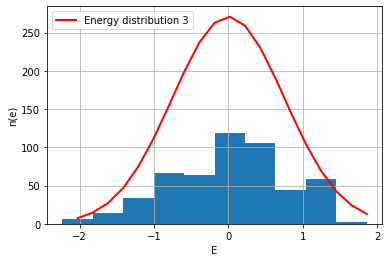

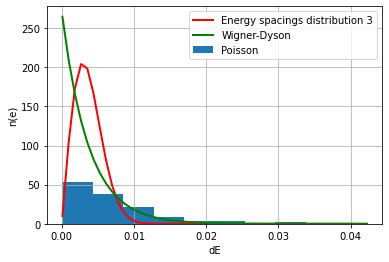

In [ ]:
Jz = 0.82
Jp = -0.41
hx2 = 0.1
hx = np.random.uniform(low=-hx2, high=hx2, size=N)
hz2 = 0
hz = np.zeros(N)
H = Hamiltonian(Jz, Jp, hx, hz)
H, _ = np.linalg.eig(H)
E = np.real_if_close(np.sort(H))

energy_levels, distribution = distrib(E)
sigma = np.sqrt(N*((Jz**2 + 2*Jp**2)/16 + (hx2**3 + hz2**3)/6))
print("sigma = {}".format(sigma))
gauss = (2**N / sigma / np.sqrt(2*np.pi)) * np.array([np.exp(-(e**2) / (2 * sigma**2)) for e in energy_levels])

central_E = np.array([e for e in E if (e >= -sigma / 3 and e <= sigma / 3)])
spacings_E = np.array([central_E[i + 1] - central_E[i] for i in range(len(central_E)-1)]) / (2*sigma / 3)
e_0 = 0
nu_0 = (2**N / sigma / np.sqrt(2*np.pi)) * np.exp(-(e_0**2) / (2 * sigma**2))

# plt.plot(energy_levels, distribution, 'g-', linewidth=2.0)
plt.hist(E, 10)
plt.plot(energy_levels, gauss, 'r-', linewidth=2.0)
plt.xlabel("E")
plt.ylabel("n(e)")
plt.legend(["Energy distribution 3"])
plt.grid()
plt.show()

min_dE = np.amin(spacings_E)
max_dE = np.amax(spacings_E)
# print("Bins = {}".format(int((10 * (max_dE - min_dE) * nu_0) / 3)))
spacings_E_coverage = np.linspace(min_dE, max_dE)
plt.hist(spacings_E)
plt.plot(spacings_E_coverage, WD_dist(spacings_E_coverage), 'r-', linewidth=2.0)
plt.plot(spacings_E_coverage, poiss_dist(spacings_E_coverage), 'g-', linewidth=2.0)
plt.xlabel("dE")
plt.ylabel("n(e)")
plt.legend(["Energy spacings distribution 3", "Wigner-Dyson", "Poisson"])
plt.grid()
plt.show()

sigma = 0.7552069252860437


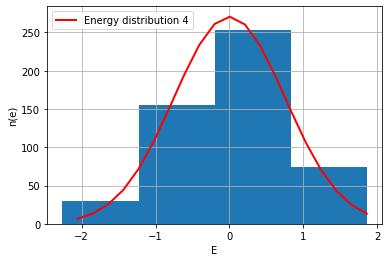

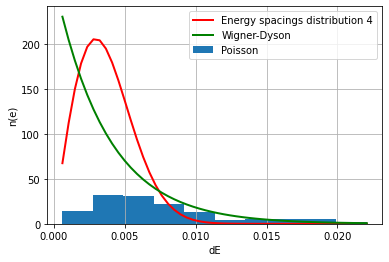

In [ ]:
Jz = 0.82
Jp = -0.41
hx2 = 0.1
hz2 = 0.1
hx = np.random.uniform(low=-hx2, high=hx2, size=N)
hz = np.random.uniform(low=-hz2, high=hz2, size=N)
H = Hamiltonian(Jz, Jp, hx, hz)
H, _ = np.linalg.eig(H)
E = np.real_if_close(np.sort(H))

energy_levels, distribution = distrib(E)
sigma = np.sqrt(N*((Jz**2 + 2*Jp**2)/16 + (hx2**3 + hz2**3)/6))
print("sigma = {}".format(sigma))
gauss = (2**N / sigma / np.sqrt(2*np.pi)) * np.array([np.exp(-(e**2) / (2 * sigma**2)) for e in energy_levels])

central_E = np.array([e for e in E if (e >= -sigma / 3 and e <= sigma / 3)])
spacings_E = np.array([central_E[i + 1] - central_E[i] for i in range(len(central_E)-1)]) / (2*sigma / 3)
e_0 = 0
nu_0 = (2**N / sigma / np.sqrt(2*np.pi)) * np.exp(-(e_0**2) / (2 * sigma**2))

# plt.plot(energy_levels, distribution, 'g-', linewidth=2.0)
plt.hist(E, 4)
plt.plot(energy_levels, gauss, 'r-', linewidth=2.0)
plt.xlabel("E")
plt.ylabel("n(e)")
plt.legend(["Energy distribution 4"])
plt.grid()
plt.show()

min_dE = np.amin(spacings_E)
max_dE = np.amax(spacings_E)
# print("Bins = {}".format(int((10 * (max_dE - min_dE) * nu_0) / 3)))
spacings_E_coverage = np.linspace(min_dE, max_dE)
plt.hist(spacings_E)
plt.plot(spacings_E_coverage, WD_dist(spacings_E_coverage), 'r-', linewidth=2.0)
plt.plot(spacings_E_coverage, poiss_dist(spacings_E_coverage), 'g-', linewidth=2.0)
plt.xlabel("dE")
plt.ylabel("n(e)")
plt.legend(["Energy spacings distribution 4", "Wigner-Dyson", "Poisson"])
plt.grid()
plt.show()

sigma = 1.7320508075688772


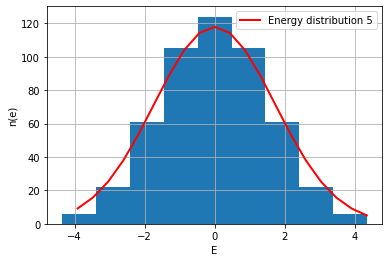

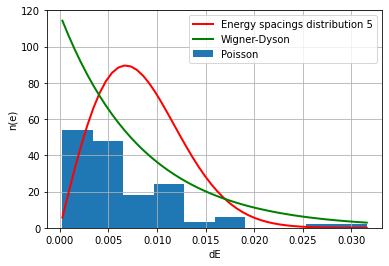

In [ ]:
Jz = 0
Jp = 0
hx2 = 1
hz2 = 1
hx = np.random.uniform(low=-hx2, high=hx2, size=N)
hz = np.random.uniform(low=-hz2, high=hz2, size=N)
H = Hamiltonian(Jz, Jp, hx, hz)
H, _ = np.linalg.eig(H)
E = np.real_if_close(np.sort(H))

energy_levels, distribution = distrib(E)
sigma = np.sqrt(N*((Jz**2 + 2*Jp**2)/16 + (hx2**3 + hz2**3)/6))
print("sigma = {}".format(sigma))
gauss = (2**N / sigma / np.sqrt(2*np.pi)) * np.array([np.exp(-(e**2) / (2 * sigma**2)) for e in energy_levels])

central_E = np.array([e for e in E if (e >= -sigma / 3 and e <= sigma / 3)])
spacings_E = np.array([central_E[i + 1] - central_E[i] for i in range(len(central_E)-1)]) / (2*sigma / 3)
e_0 = 0
nu_0 = (2**N / sigma / np.sqrt(2*np.pi)) * np.exp(-(e_0**2) / (2 * sigma**2))

# plt.plot(energy_levels, distribution, 'g-', linewidth=2.0)
plt.hist(E, 9)
plt.plot(energy_levels, gauss, 'r-', linewidth=2.0)
plt.xlabel("E")
plt.ylabel("n(e)")
plt.legend(["Energy distribution 5"])
plt.grid()
plt.show()

min_dE = np.amin(spacings_E)
max_dE = np.amax(spacings_E)
# print("Bins = {}".format(int((10 * (max_dE - min_dE) * nu_0) / 3)))
spacings_E_coverage = np.linspace(min_dE, max_dE)
plt.hist(spacings_E)
plt.plot(spacings_E_coverage, WD_dist(spacings_E_coverage), 'r-', linewidth=2.0)
plt.plot(spacings_E_coverage, poiss_dist(spacings_E_coverage), 'g-', linewidth=2.0)
plt.xlabel("dE")
plt.ylabel("n(e)")
plt.legend(["Energy spacings distribution 5", "Wigner-Dyson", "Poisson"])
plt.grid()
plt.show()